# Code Challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import RandomSearch

# a) Generating a dataset. 

Use make_moons to simulate a data set: 
```python
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
```
After you have generated it, check the shape, print out some rows of it and also do a plot: 

```python
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data generated by make_moons() function')
```

Text(0.5, 1.0, 'Data generated by make_moons() function')

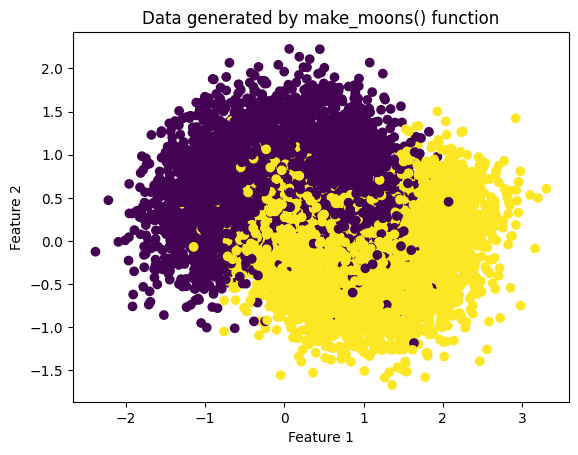

In [2]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data generated by make_moons() function')

In [3]:
# Inspecting our data
print(X.shape)
print(y.shape)

print()
print(y)
print()
print(X)

(10000, 2)
(10000,)

[1 0 0 ... 1 0 1]

[[ 0.9402914   0.12230559]
 [ 0.12454026 -0.42477546]
 [ 0.26198823  0.50841438]
 ...
 [-0.24177973  0.20957199]
 [ 0.90679645  0.54958215]
 [ 2.08837082 -0.05050728]]


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1) 

# b) Now you will do some modelling from beginning to end meaning that you will have to decide how to split your data, what model to use and so on.
# Create 1 model with Scikit-learn. 
# Create 1 deep learning model. Try to tune hyperparameters with KerasTuner: https://keras.io/keras_tuner/ .
# Write down a short summary of your conclusions. 

## ML model with Scikit-learn

In [5]:
tree_clf = DecisionTreeClassifier(random_state=42)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(tree_clf, params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [6]:
grid_search_cv.best_params_

{'max_leaf_nodes': 17, 'min_samples_split': 2}

## Neural Network model with Keras

In [7]:
n_cols = X_train.shape[1]

nn_model = Sequential()
nn_model.add(Dense(100, activation = 'relu', input_shape = (n_cols, )))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(50, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

In [8]:
nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
early_stopping_monitor = EarlyStopping(patience = 5)
nn_model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping_monitor], verbose = False)

## Neural network, choosing hyperparameters with KerasTuner

In [10]:
def build_model(hp):
    n_cols = X_train.shape[1]
    nn_model = keras.Sequential()
    
    # Tune the number of units in the first dense layer
    hp_units_1 = hp.Int('units', min_value=30, max_value=200, step=10)
    nn_model.add(Dense(units=hp_units_1, activation='relu', input_shape=(n_cols,)))
    
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
    # Tune the dropout rate
        hp_dropout_rate = hp.Choice('dropout_rate', values=[i * 0.05 for i in range(12)])
        nn_model.add(Dropout(rate=hp_dropout_rate))
    
    # Tune the number of units in the second dense layer
    hp_units_2 = hp.Int('units', min_value=10, max_value=220, step=10)
    nn_model.add(Dense(units=hp_units_2, activation='relu'))
    
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
    # Tune the dropout rate
        hp_dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
        nn_model.add(Dropout(rate=hp_dropout_rate))
    
    # Tune number of layers
    for i in range(hp.Int("num_layers", 1, 3)):
        nn_model.add(Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=10, max_value=150, step=5),
                activation='relu')) 
    
    nn_model.add(Dense(1, activation='sigmoid'))
    
    nn_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    
    return nn_model


In [11]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, 
    overwrite=True,
)

In [12]:
# tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=3, callbacks=[early_stopping_monitor], verbose=2)
tuner.search(X_train, y_train, validation_split=0.2, epochs=3, callbacks=[early_stopping_monitor], verbose=2)

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.835156261920929

Best val_accuracy So Far: 0.848437488079071
Total elapsed time: 00h 00m 26s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
units: 70
dropout: False
num_layers: 2
units_0: 50
units_1: 40
units_2: 60
Score: 0.848437488079071

Trial 05 summary
Hyperparameters:
units: 200
dropout: False
num_layers: 3
units_0: 25
units_1: 75
units_2: 45
dropout_rate: 0.25
Score: 0.84765625

Trial 07 summary
Hyperparameters:
units: 100
dropout: False
num_layers: 1
units_0: 10
units_1: 80
units_2: 130
dropout_rate: 0.35000000000000003
Score: 0.844531238079071

Trial 04 summary
Hyperparameters:
units: 100
dropout: True
num_layers: 2
units_0: 105
units_1: 10
units_2: 120
dropout_rate: 0.05
Score: 0.84375

Trial 06 summary
Hyperparameters:
units: 190
dropout: False
num_layers: 1
units_0: 135
units_1: 80
units_2: 120
dropout_rate: 0.55
Score: 0.8414062261581421

Trial 00 summary
Hyperparameters:
units: 50
dropout: False
num_layers: 3
units_0: 80
units_1: 10
units_2: 10
Score: 0.836718

In [14]:
# Get the top 2 models.
tuned_nn = tuner.get_best_models(num_models=2)[0]
tuned_nn.build()

In [15]:
tuned_nn.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping_monitor], verbose=False)

# Comparing models in validation data

### Evaluating our Sklearn model

In [16]:
tree_pred_val = grid_search_cv.predict(X_val)
tree_pred_val

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [17]:
tree_pred_val.shape

(1600,)

In [18]:
accuracy_score(y_val, tree_pred_val)

0.85375

### Evaluating our simple nn

In [19]:
nn_pred_val = nn_model.predict(X_val)

# Returns probabilities
print(nn_pred_val)

50/50 [==============================] - 0s 1ms/step
[[0.22962269]
 [0.0447466 ]
 [0.6299349 ]
 ...
 [0.00369483]
 [0.99187803]
 [0.6913872 ]]


In [20]:
# Transforming to predicted classes instead of probabilities

# https://stackoverflow.com/questions/68776790/model-predict-classes-is-deprecated-what-to-use-instead
threshold = 0.5
nn_pred_val_label = np.where(nn_pred_val > threshold, 1,0)

print(nn_pred_val_label)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


In [21]:
accuracy_score(y_val, nn_pred_val_label)

0.849375

### Evaluating our tuned Neural Network

In [22]:
tuned_nn_pred_val = tuned_nn.predict(X_val)
print(tuned_nn_pred_val)

50/50 [==============================] - 0s 1ms/step
[[0.24273191]
 [0.02739285]
 [0.70280504]
 ...
 [0.0069807 ]
 [0.98903567]
 [0.7380507 ]]


In [23]:
threshold = 0.5
tuned_nn_pred_val_label = np.where(tuned_nn_pred_val > threshold, 1,0)
print(tuned_nn_pred_val_label)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


In [24]:
accuracy_score(y_val, tuned_nn_pred_val_label)

0.8525

# Refitting our model on the train and validation data before evaluating it on the test data

In [25]:
best_model = grid_search_cv.best_estimator_.fit(X_train_val, y_train_val)

In [26]:
test_predictions = best_model.predict(X_test)

In [27]:
accuracy_score(y_test, test_predictions)

0.8465